Dorado Code for Inserting and Tracking Particles and Estimating Particle and Water Fluxes at a Specific (x,y,t)
Input: Overland flow data, area of wildfire land
Output: pH of water downstream

In [109]:
# Install and import
!pip install pydorado  # install the particle routing package
!pip install matplotlib pillow
!pip install pickle-mixin
!pip install xarray

# libraries for loading our data
import pickle  # to access 'pickled' compressed data
import xarray as xr  # to load 'dimensional' data stored in netCDF files

# standard libraries for arrays and plots
import numpy as np  # base array manipulation library
import matplotlib.pyplot as plt  # standard plotting library

# library for particle simulation
import dorado
import pandas as pd 
from PIL import Image
import os
from PIL import Image
import math

!wget 'https://utexas.box.com/shared/static/7qr4hqneb3b30xc5amr4kv3vyjgp0sy2.pkl' -O 'RoyGPark.pkl'

# some pyDeltaRCM model outputs with different input sand fractions
!wget 'https://utexas.box.com/shared/static/tjvr9o7oyt6hthherhaubxlkx6d6e4m7.xz' -O 'pyDeltaRCM_outputs.tar.xz

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
--2024-08-05 19:41:10--  https://utexas.box.com/shared/static/7qr4hqneb3b30xc5amr4kv3vyjgp0sy2.pkl
Resolving utexas.box.com (utexas.box.com)... 74.112.186.157
Connecting to utexas.box.com (utexas.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/7qr4hqneb3b30xc5amr4kv3vyjgp0sy2.pkl [following]
--2024-08-05 19:41:10--  https://utexas.box.com/public/static/7qr4hqneb3b30xc5amr4kv3vyjgp0sy2.pkl
Reusing existing connection to utexas.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://utexas.app.box.com/public/static/7qr4hqneb3b30xc5amr4kv3vyjgp0sy2.pkl [following]
-

In [110]:
import warnings
warnings.filterwarnings('error', category=DeprecationWarning)
with open('RoyGPark.pkl', 'rb') as f:
  royg = pickle.load(f)

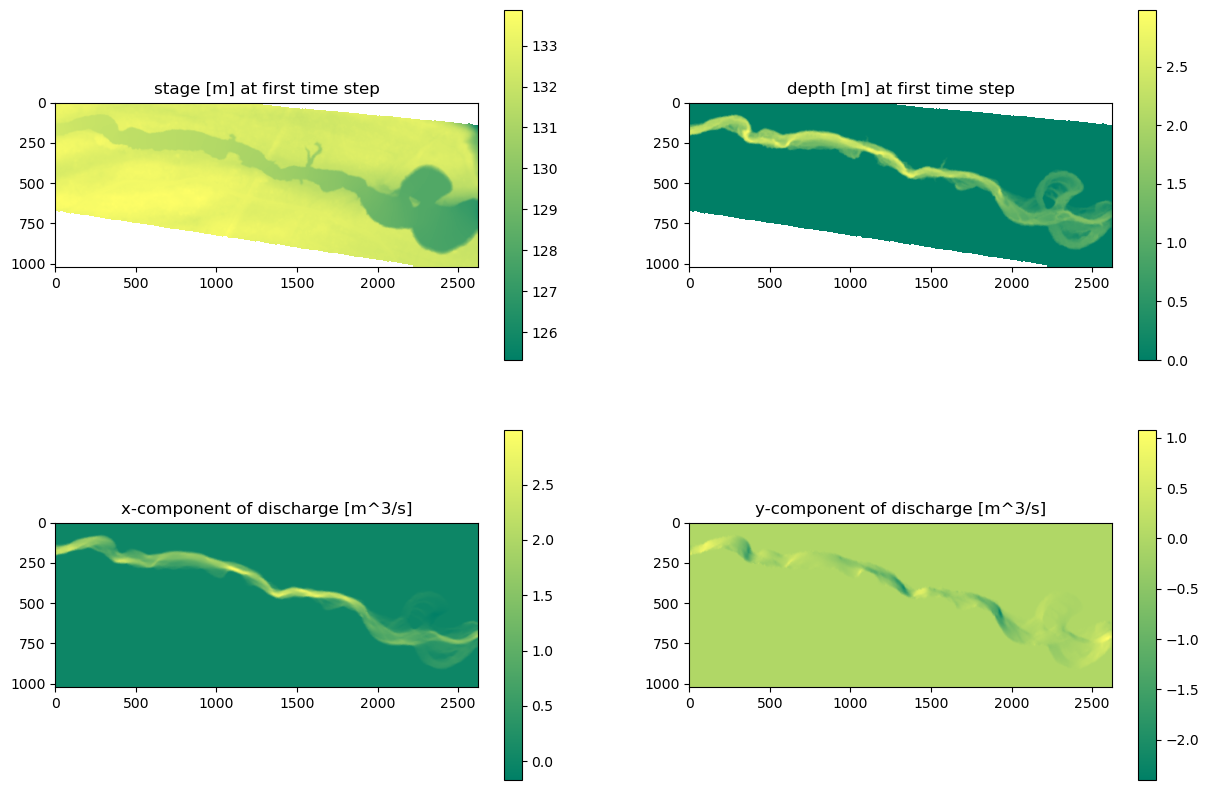

In [111]:
# ## Make a bunch of plots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))  # sets up a 2x2 set of axes

c1 = ax[0, 0].imshow(royg['stage'],cmap='summer')  # shows the stage grid
ax[0, 0].set_title('stage [m] at first time step')  # title for stage grid
fig.colorbar(c1, ax=ax[0, 0])

c2 = ax[0, 1].imshow(royg['depth'],cmap='summer')  # shows the depth grid
ax[0, 1].set_title('depth [m] at first time step')  # title for depth grid
fig.colorbar(c2, ax=ax[0, 1])

c3 = ax[1, 0].imshow(royg['qx'],cmap='summer')  # plots variable qx
ax[1, 0].set_title('x-component of discharge [m^3/s]')  # title
fig.colorbar(c3, ax=ax[1, 0])
             
c4 = ax[1, 1].imshow(royg['qy'],cmap='summer')  # plots variable qy
ax[1, 1].set_title('y-component of discharge [m^3/s]')  # title
fig.colorbar(c4, ax=ax[1, 1])

plt.show()  # displays the plot


In [124]:
# Load Params
# for any particle simulation, we start by defining model parameters
params = dorado.particle_track.modelParams()

params.dx = royg['dx']
print(params.dx)

# provide information about the flow field
params.depth = royg['depth']
params.stage = royg['stage'].copy()
params.qx = royg['qx']
params.qy = royg['qy']

# finally we tell the model what hydrodynamic model we are using
params.model = 'ANUGA'

5.0


Let's decide on the number of ash particles we want to place at the start of the stream. We assume each particle is equal to 0.5kg of ash. Enter in how many m^2 of burnt land we want to consider. We also assume 1m^2 of land = 1.6 kg/m^2 of ash [1].


1. Santín, C., Doerr, S. H., Otero, X. L., & Chafer, C. J. (2015). Quantity, composition and water contamination potential of ash produced under different wildfire severities. Environmental Research, 142, 297-308.

In [115]:
particles = dorado.particle_track.Particles(params)  # supply model parameters
# Location of ash particles
seed_xloc = [175]
seed_yloc = [50]
## User Input: Area of burnt land m^2
a_f = 30
m_ash = a_f * 1.6
Np_tracer = round(m_ash/0.5)
print(Np_tracer)
# generate particles
particles.generate_particles(Np_tracer, seed_xloc, seed_yloc)

Theta parameter not specified - using 1.0
Gamma parameter not specified - using 0.05
Diffusion coefficient not specified - using 0.2
minimum depth for wetness not defined - using 10 cm
Cell Types not specified - Estimating from depth
Using weighted random walk
96


In [116]:
# now route the particles for a set time (in seconds)
tt = 5*60*60  # 5 hours in seconds
walk_data = particles.run_iteration(target_time=tt)
wd = walk_data
DF = pd.DataFrame(wd) 
fnm = "park_walkdata_" + str(i) + ".csv"
DF.to_csv(fnm)

<Axes: >

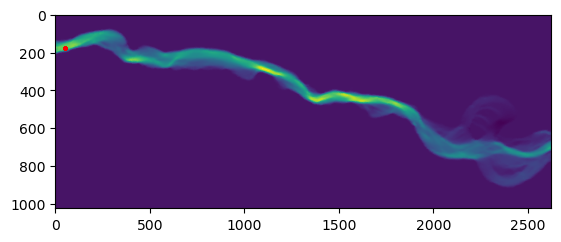

In [117]:
dorado.routines.plot_state(royg['qx'], walk_data, iteration=0, c='r')

In [118]:
plt.rcParams.update({'lines.markersize': 2})

frames = []
t_step = 15*60
frames_dir = 'frames'
for i in range(0, tt+t_step, t_step):
  dorado.routines.plot_state(
      royg['stage'], walk_data, target_time=i, c='r')
  plt.title(str(i/60/60) + ' hours')
  frame_filename = f'park_frame_{i:03d}.png'
  plt.savefig(frame_filename)
  plt.close()
  frames.append(Image.open(frame_filename))

Note: Particle 25 never reached target_time
Note: Particle 90 never reached target_time
Note: Particle 13 never reached target_time
Note: Particle 14 never reached target_time
Note: Particle 17 never reached target_time
Note: Particle 19 never reached target_time
Note: Particle 20 never reached target_time
Note: Particle 22 never reached target_time
Note: Particle 25 never reached target_time
Note: Particle 33 never reached target_time
Note: Particle 38 never reached target_time
Note: Particle 41 never reached target_time
Note: Particle 45 never reached target_time
Note: Particle 48 never reached target_time
Note: Particle 55 never reached target_time
Note: Particle 57 never reached target_time
Note: Particle 77 never reached target_time
Note: Particle 85 never reached target_time
Note: Particle 86 never reached target_time
Note: Particle 88 never reached target_time
Note: Particle 90 never reached target_time
Note: Particle 91 never reached target_time
Note: Particle 1 never reached t

In [123]:
gif_filename = 'animation_park.gif'
frames[0].save(gif_filename, save_all=True, append_images=frames[1:], duration=101, loop=10)

In [120]:
# count number of partical in target region
file_path = 'park_walkdata_18000.csv'
data = pd.read_csv(file_path)
# Extract the last x and y coordinates for each particle
data['last_x'] = data['xinds'].apply(lambda x: int(x.strip('[]').split(',')[-1]))
data['last_y'] = data['yinds'].apply(lambda y: int(y.strip('[]').split(',')[-1]))
# Count the number of particles in the specified region
particles_in_region = data[(data['last_x'] >= 600) & (data['last_x'] <= 800) & (data['last_y'] >= 2500)]
total_particle = len(particles_in_region)
print(total_particle)

46


In [121]:
# Determine the average discharge for the area of interest
# Assuming royg['qx'] and royg['qy'] have been loaded as params.qx and params.qy
qx = royg['qx']
qy = royg['qy']

# Define the region of interest
x_min, x_max = 600, 800
y_min = 2500

# Extract the region from qx and qy
qx_region = qx[x_min:x_max+1, y_min:]
qy_region = qy[x_min:x_max+1, y_min:]

# Calculate the magnitude of the vectors in the region
magnitude = np.sqrt(qx_region**2 + qy_region**2)

# Integrate (sum) the magnitudes within the region
total_magnitude = np.mean(magnitude) * tt

Now, let's estimate the pH of the water downstream due to the KOH in the transported ash. A solution above 7 is basic.
References: 
2. Etiegni, L., & Campbell, A. G. (1991). Physical and chemical characteristics of wood ash. Bioresource technology, 37(2), 173-178.

In [122]:
# pH Calculation
# Define Area of Interest
# number of particles
m_ash = total_particle * 0.5
m_KC = 0.08 * m_ash # [2]
mol_KC = ((138.21e-3)/m_KC)**(-1)
mol_KOH = 2*mol_KC
M = (mol_KOH/(total_magnitude*1e3))
pOH = (math.log(M,10))
pH = 14+pOH
print('pH = ')
print(pH)

pH = 
8.428009356914202


Overall Question:
    - How does the size of the land area affected by the wild fire affect the pH of the water downstream?